In [3]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import os
from PIL import Image
import numpy as np
import seaborn as sns

In [18]:
df.loc[df['fitzpatrick_scale'] != -1];

In [11]:
csv_file = 'fitzpatrick17k.csv'#'fitzpatrick17k.csv'
df = pd.read_csv(csv_file)
fig_folder = 'Figures/'

In [16]:
# drop unknown skin type
df_known = df.loc[df['fitzpatrick_scale'] != -1]

In [17]:
df_known['fitzpatrick_scale'].unique()

array([3, 1, 2, 6, 4, 5])

In [30]:
# encode disease names to numbers
df_known["low"] = df_known['label'].astype('category').cat.codes
df_known["mid"] = df_known['nine_partition_label'].astype('category').cat.codes
df_known["high"] = df_known['three_partition_label'].astype('category').cat.codes
df_known["hasher"] = df_known["md5hash"]

/tmp/ipykernel_186496/2244933352.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_known["low"] = df_known['label'].astype('category').cat.codes
/tmp/ipykernel_186496/2244933352.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_known["mid"] = df_known['nine_partition_label'].astype('category').cat.codes
/tmp/ipykernel_186496/2244933352.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [31]:
new_path = 'fitapatrick17k_known_code.csv'
df_known.to_csv(new_path, index=False)

In [32]:
code_df = pd.read_csv('fitapatrick17k_known_code.csv')

In [34]:
code_df["high"]

0        2
1        2
2        0
3        2
4        2
        ..
16007    2
16008    2
16009    2
16010    2
16011    2
Name: high, Length: 16012, dtype: int64

In [35]:
'''
calculate weights for each skin type and condition
method 1 reweighting
'''
level = 'high'
total = code_df['fitzpatrick_scale'].count()  # total samples
type_count = code_df['fitzpatrick_scale'].value_counts().sort_index()
condition_count = code_df[level].value_counts().sort_index()
print(total)
print(type_count)
print(type_count[1])
print(condition_count)
weight_record = np.zeros((7, 3))
num_record = np.zeros((7, 3))
for i in range(1, 7): # skin type
    for j in range(len(condition_count)): # skin condition
        x = code_df.loc[(code_df['fitzpatrick_scale']==i) & (code_df[level]==j)]
        num_record[i, j] = len(x)
        # print('joint num', len(x))
        weight = type_count[i]*condition_count[j]/(len(x)*total)
        # print('weight', weight)
        weight_record[i, j] = weight
print(weight_record)
print(num_record)
# add weights to the csv file
weight_list = []  # weight for each sample in the code_df
for k in range(total):
    row_data = code_df.iloc[k]
    # print(row_data)
    weight_list.append(weight_record[int(row_data['fitzpatrick_scale']), int(row_data[level])])
    # print(weight_list)
print(len(weight_list))
code_df['REWT_weights'] = weight_list

16012
fitzpatrick_scale
1    2947
2    4808
3    3308
4    2781
5    1533
6     635
Name: count, dtype: int64
2947
high
0     2160
1     2160
2    11692
Name: count, dtype: int64
[[0.         0.         0.        ]
 [0.89537577 0.87758684 1.0497104 ]
 [0.96660738 0.8741153  1.03411278]
 [0.93946382 0.97860815 1.01620083]
 [1.02221699 1.24635759 0.9610472 ]
 [1.3006283  1.40680204 0.9123066 ]
 [1.94683533 1.40427466 0.87486508]]
[[   0.    0.    0.]
 [ 444.  453. 2050.]
 [ 671.  742. 3395.]
 [ 475.  456. 2377.]
 [ 367.  301. 2113.]
 [ 159.  147. 1227.]
 [  44.   61.  530.]]
16012


In [36]:
code_df.to_csv('fitzpatrick17k_known_code.csv', index=False)

In [38]:
'''
calculate weights for each skin type and condition
method 2 resampling   weight=1/num
'''
level = 'high'
total = code_df['fitzpatrick_scale'].count()  # total samples
type_count = code_df['fitzpatrick_scale'].value_counts().sort_index()
condition_count = code_df[level].value_counts().sort_index()
weight_record = np.zeros((7, 3))
num_record = np.zeros((7, 3))
for i in range(1, 7): # skin type
    for j in range(len(condition_count)): # skin condition
        x = code_df.loc[(code_df['fitzpatrick_scale']==i) & (code_df[level]==j)]
        num_record[i, j] = len(x)
        # print('joint num', len(x))
        weight = 1/len(x)
        # print('weight', weight)
        weight_record[i, j] = weight
# print(num_record)
print(weight_record)
# add weights to the csv file
weight_list = []  # weight for each sample in the code_df
for k in range(total):
    row_data = code_df.iloc[k]
    # print(row_data)
    weight_list.append(weight_record[int(row_data['fitzpatrick_scale']), int(row_data[level])])
    # print(weight_list)
print(len(weight_list))
code_df['RESM_weights'] = weight_list

[[0.         0.         0.        ]
 [0.00225225 0.00220751 0.0004878 ]
 [0.00149031 0.00134771 0.00029455]
 [0.00210526 0.00219298 0.0004207 ]
 [0.0027248  0.00332226 0.00047326]
 [0.00628931 0.00680272 0.000815  ]
 [0.02272727 0.01639344 0.00188679]]
16012


In [39]:
code_df.to_csv('fitzpatrick17k_known_code.csv', index=False)

In [40]:
# connect class number and class name
connection = {}
name_list = {'low':'label', 'mid':'nine_partition_label', 'high':'three_partition_label'}
connection['low'] = [0]*114
connection['mid'] = [0]*9
connection['high'] = [0]*3
for label in ['low', 'mid', 'high']:
    for i in range(len(connection[label])):
        capture = code_df.loc[code_df[label]==i].iloc[0][name_list[label]]
        connection[label][i] = capture
print(connection)

{'low': ['acanthosis nigricans', 'acne', 'acne vulgaris', 'acquired autoimmune bullous diseaseherpes gestationis', 'acrodermatitis enteropathica', 'actinic keratosis', 'allergic contact dermatitis', 'aplasia cutis', 'basal cell carcinoma', 'basal cell carcinoma morpheiform', 'becker nevus', 'behcets disease', 'calcinosis cutis', 'cheilitis', 'congenital nevus', 'dariers disease', 'dermatofibroma', 'dermatomyositis', 'disseminated actinic porokeratosis', 'drug eruption', 'drug induced pigmentary changes', 'dyshidrotic eczema', 'eczema', 'ehlers danlos syndrome', 'epidermal nevus', 'epidermolysis bullosa', 'erythema annulare centrifigum', 'erythema elevatum diutinum', 'erythema multiforme', 'erythema nodosum', 'factitial dermatitis', 'fixed eruptions', 'folliculitis', 'fordyce spots', 'granuloma annulare', 'granuloma pyogenic', 'hailey hailey disease', 'halo nevus', 'hidradenitis', 'ichthyosis vulgaris', 'incontinentia pigmenti', 'juvenile xanthogranuloma', 'kaposi sarcoma', 'keloid', 'k

In [41]:
'''
Look into Derm/Atla
'''
derm = code_df.loc[code_df.url.str.contains("dermaamin")==False]
value_counts = derm['low'].value_counts()
value_counts = value_counts.rename_axis('unique_values').reset_index(name='counts')
print(value_counts)
final_set = set((value_counts.loc[value_counts['counts']>1])['unique_values'])
print(len(final_set))

    unique_values  counts
0               8     253
1              48     225
2              98     196
3              80     172
4              92     126
..            ...     ...
87             22       2
88             74       2
89             72       2
90             24       2
91             53       1

[92 rows x 2 columns]
91


fitzpatrick_scale
2    4137
1    2780
3    2298
4    1689
5     891
6     427
Name: count, dtype: int64


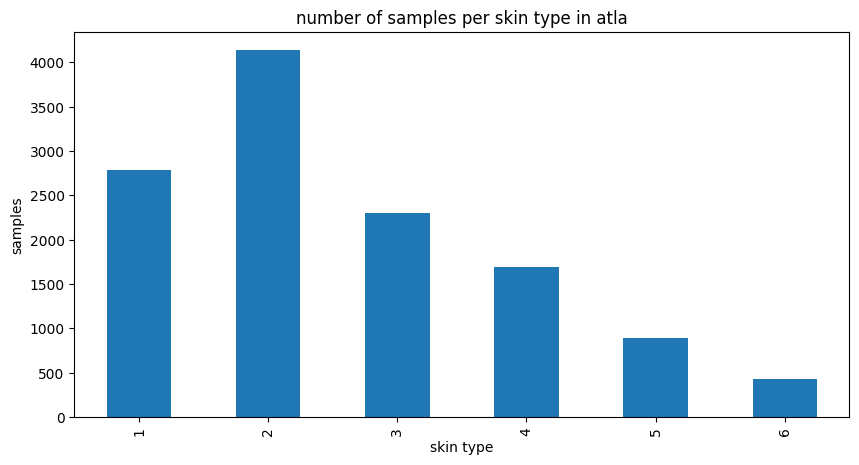

In [45]:
'''
Visualize data distribution
'''
plt.figure(figsize=(10,5))
type = code_df['fitzpatrick_scale']
# for derm
derm = code_df.loc[code_df.url.str.contains("dermaamin")==True]
type = derm['fitzpatrick_scale']
print(type.value_counts())
type.value_counts().sort_index().plot.bar()
plt.xlabel('skin type')
plt.ylabel('samples')
plt.title('number of samples per skin type in atla')
# plt.savefig(fig_folder+'skin_type_statistics.jpg')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Figures/high_class_statistics.jpg'

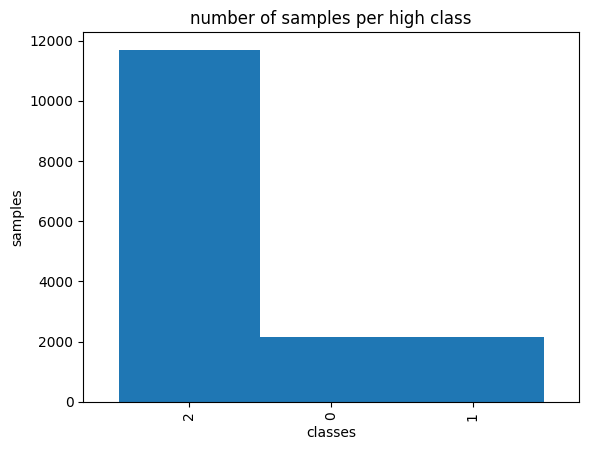

In [46]:
'''
Visualize Skin type distribution
'''
# count number of samples for each skin condition
# plt.figure(figsize=(25, 5), dpi=200)
plt.figure()
phase = 'high'
label = code_df[phase]
label.value_counts().plot.bar(width=1)
# plt.hist(count_condition.values, bins=200)
# plt.title('Histogram age_approx counts in train')
plt.xlabel('classes')
plt.ylabel('samples')
# plt.xticks([])
plt.title('number of samples per {} class'.format(phase))
plt.savefig(fig_folder+'{}_class_statistics.jpg'.format(phase))
plt.show()
# print(count_condition)

acrodermatitis enteropathica
number of samples 87


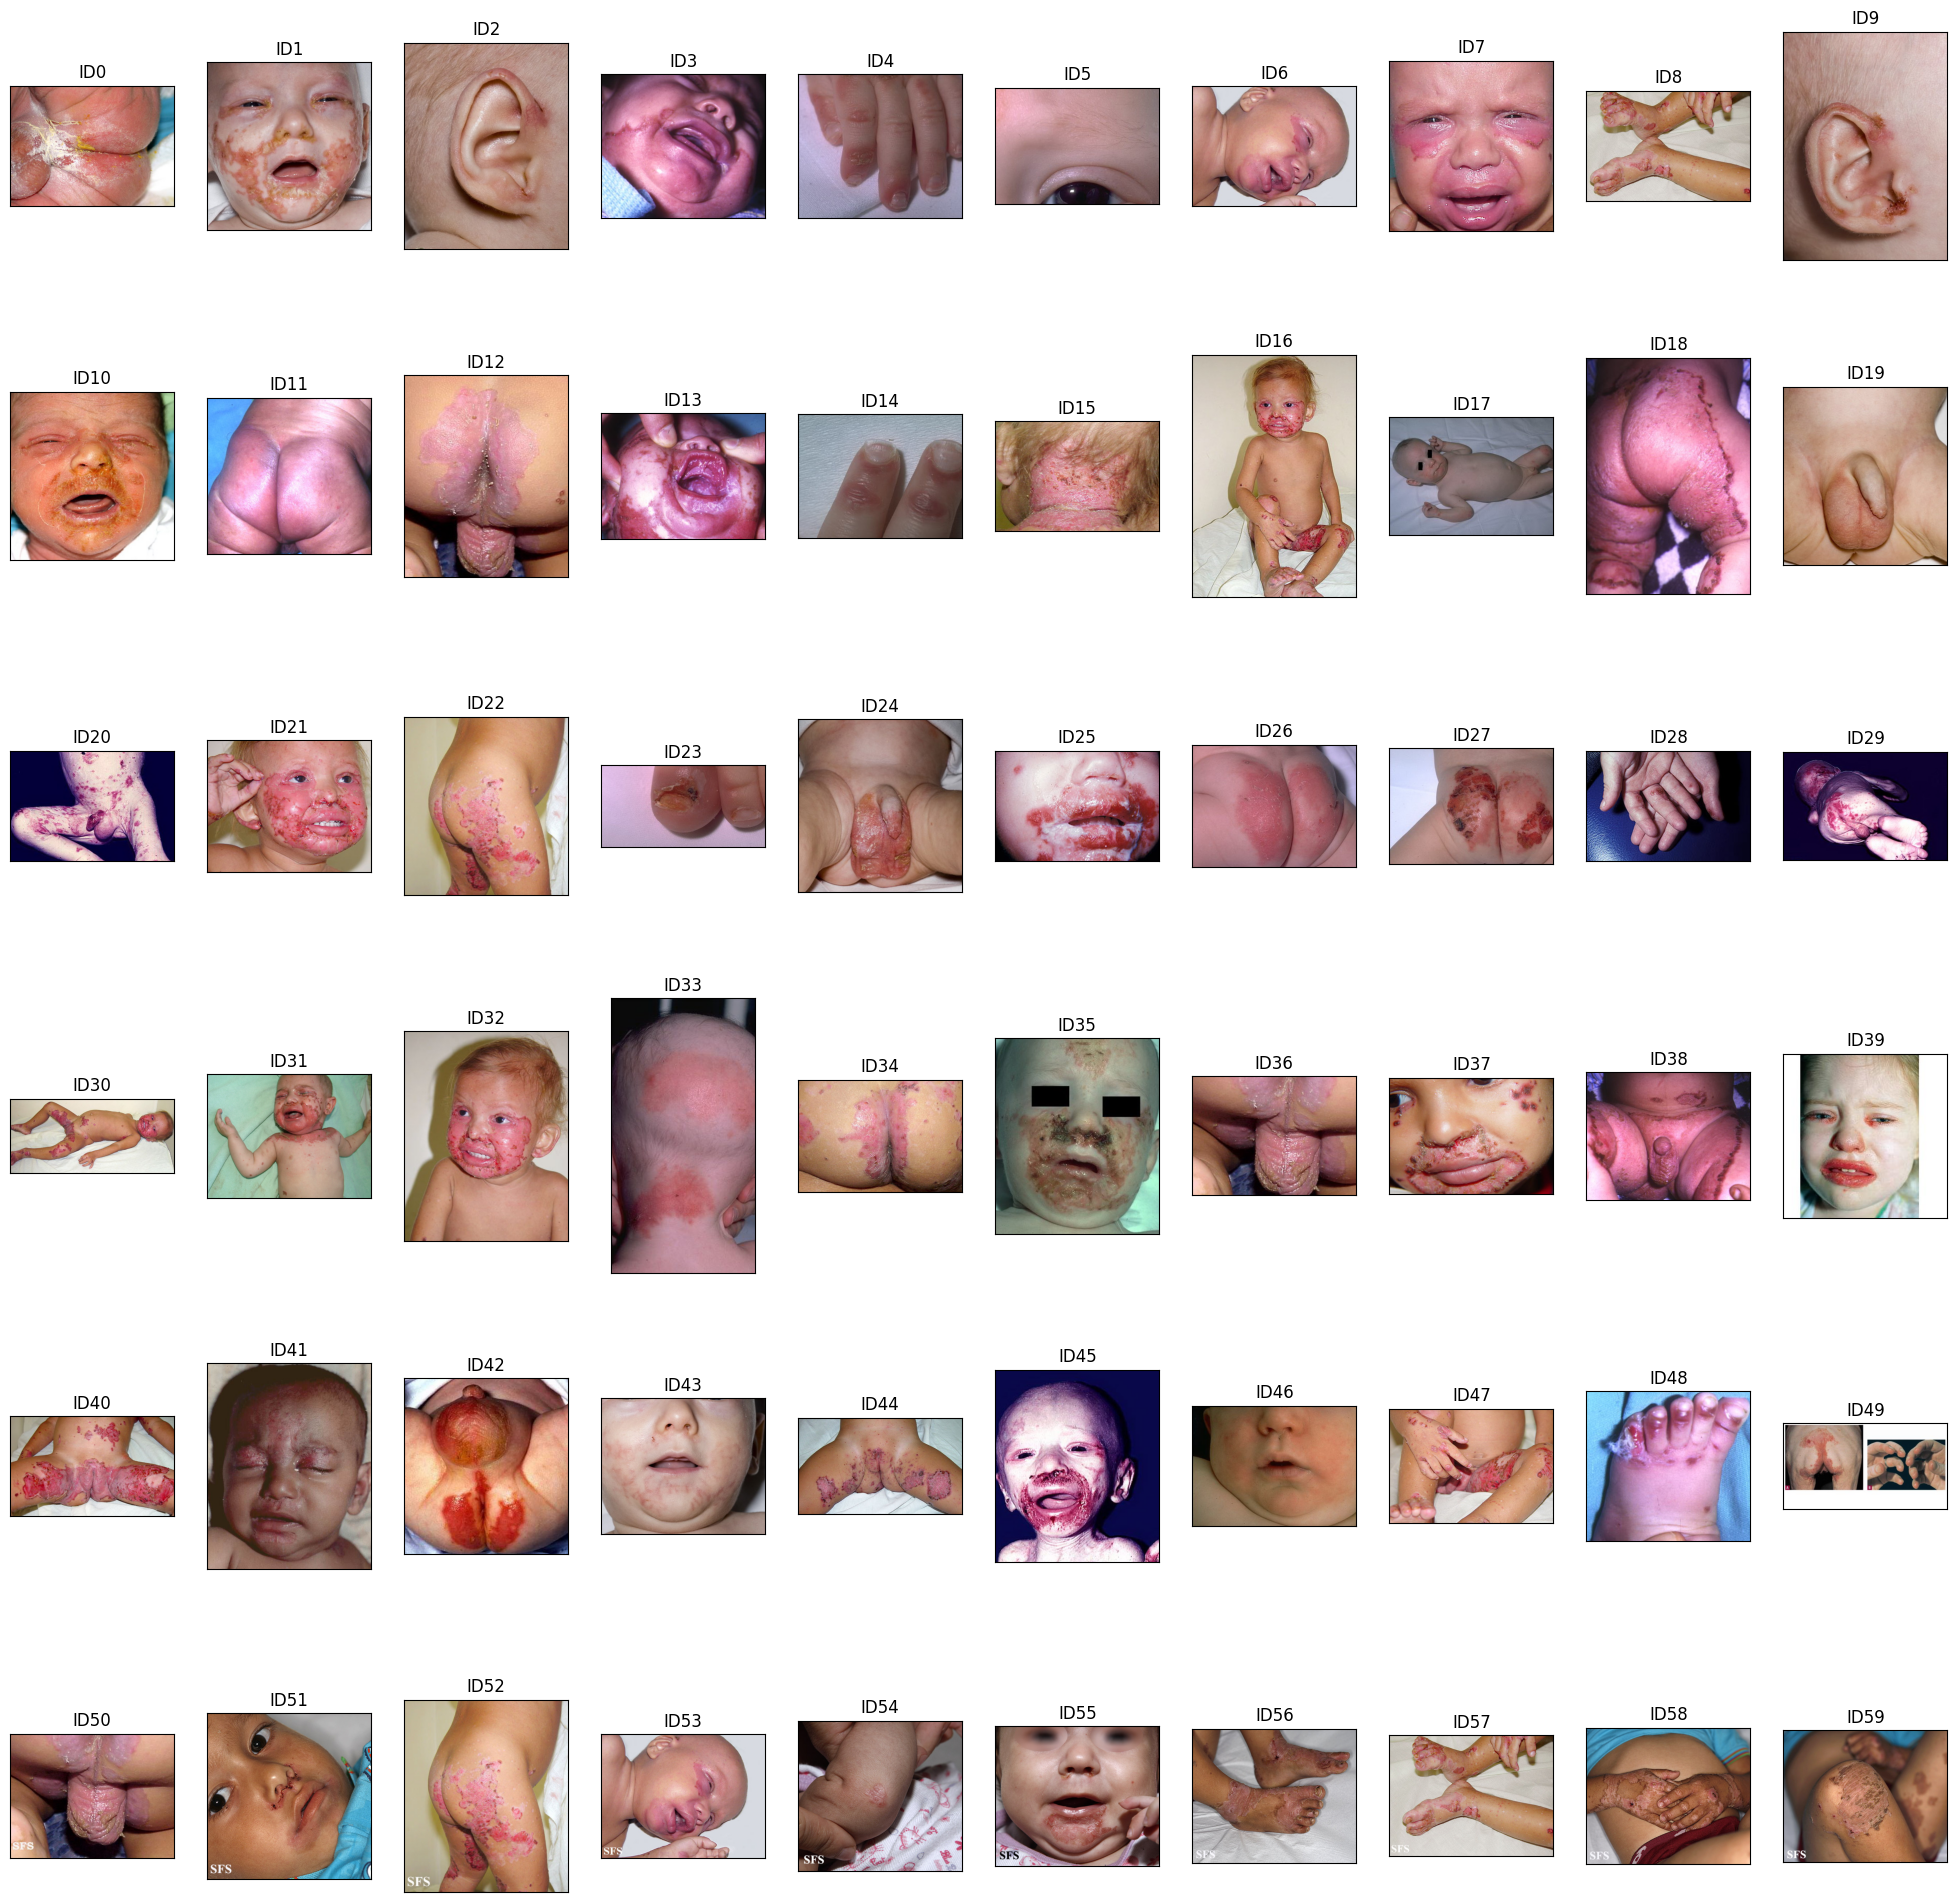

In [48]:
'''
Visualize some images of one class
'''
img_folder = 'fitzpatrick17k/data/finalfitz17k/'
group_condition = list(code_df.groupby('label'))
fig = plt.figure(figsize=(25,25))
want_label = 4
get_index = -1
for i in range(len(group_condition)):
    if group_condition[i][1].iloc[0]['low'] == want_label:
        get_index = i
data = group_condition[get_index][1]
print(group_condition[get_index][0])
print('number of samples', data.shape[0])
for i in range(1, 61):
    fig.add_subplot(6, 10, i)
    img_name = img_folder+data.iloc[i]['md5hash']+'.jpg'
    img = Image.open(img_name)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title('ID'+str(i-1))

plt.pause(0.001)
plt.show()


    


[[   0.    0.    0.]
 [ 444.  453. 2050.]
 [ 671.  742. 3395.]
 [ 475.  456. 2377.]
 [ 367.  301. 2113.]
 [ 159.  147. 1227.]
 [  44.   61.  530.]
 [   0.    0.    0.]]
[ 2160.  2160. 11692.]
[   0. 2947. 4808. 3308. 2781. 1533.  635.    0.]
16012.0


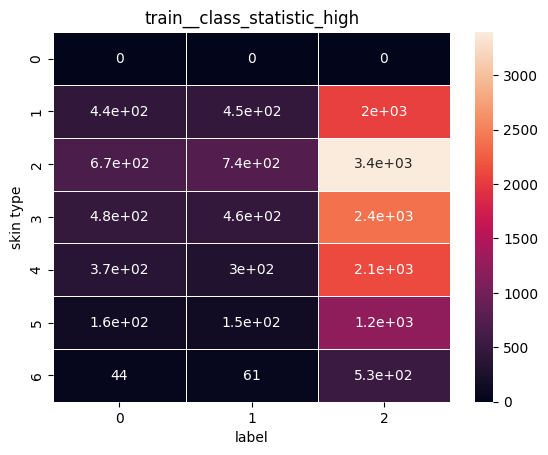

In [51]:
'''get number of samples per skin type per class  with unknown type
'''
np.set_printoptions(suppress=True)
label = 'high'
# fig_folder = 'figures/'
df = pd.read_csv('fitzpatrick17k_known_code.csv')
whole = np.zeros((8, len(df[label].unique())))  # whole samples

for i in range(df.shape[0]):
    row = df.iloc[i]
    type = int(row['fitzpatrick_scale']) if row['fitzpatrick_scale'] > 0 else 0  # set type -1 as 0
    whole[type, row[label]] += 1

print(whole)
print(np.sum(whole, axis=0))
print(np.sum(whole, axis=1))
print(np.sum(whole))
# calculate row 7. sum row 0-6        
# whole[7, :] = np.sum(whole[0:7, :], axis=0)

# plot
# plt.figure(figsize=(100,8), dpi=200)
# sns.heatmap(record_array[0:7, :], annot=True, fmt=".2g", linewidths=.5)
sns.heatmap(whole[0:7, :], annot=True, fmt=".2g", linewidths=.5)
plt.xlabel('label')
plt.ylabel('skin type')
name = 'train__class_statistic_{}'.format(label)
plt.title(name)
# plt.savefig(fig_folder+name+'.jpg')
plt.show()

In [52]:
'''get number of samples per skin type per class  out  unknown type
'''
np.set_printoptions(suppress=True)
label = 'low'
# fig_folder = 'figures/'
df = pd.read_csv('temp_test.csv')
whole = np.zeros((8, len(df[label].unique())))  # whole samples

for i in range(df.shape[0]):
    row = df.iloc[i]
    type = int(row['fitzpatrick_scale']) 
    whole[type, row[label]] += 1

# calculate row 7. sum row 0-6        
whole[7, :] = np.sum(whole[0:7, :], axis=0)

# plot
plt.figure(figsize=(100,8), dpi=200)
# sns.heatmap(record_array[0:7, :], annot=True, fmt=".2g", linewidths=.5)
sns.heatmap(whole[1:7, :], annot=True, fmt=".2g", linewidths=.5)
plt.xlabel('label')
plt.ylabel('skin type')
name = 'train__class_statistic_{}'.format(label)
plt.title(name)
# plt.savefig(fig_folder+name+'.jpg')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'temp_test.csv'